In [1]:
from pathlib import Path 
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from threading import Lock
import re


import pandas as pd 
import numpy as np 




In [2]:
path = Path('../data/')


dataverse_path =  path / 'dataverse_files'


partitions_list = [


    'partition4_instances', # revert back to 3 later

    
    ]



In [3]:

def parse_partition(partions_list, dataverse_path,filename=None, max_workers=3):

    feature_list_summaries = [ 'TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH',
       'SAVNCPP', 'USFLUX', 'TOTFZ', 'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45',
       'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZH', 'TOTFY',
       'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'R_VALUE']
    
    descriptors = [
    'Max',
    'Min',
    'Median',
    'Mean',
    'Std',
    'Variance',
    'Skewness',
    'Kurtosis'
        ]
    




    # First pass: collect all files to show total progress
    all_files = []
    for partition_inst in partitions_list:
        partition_inst_path = dataverse_path / partition_inst
        partition_num = partition_inst.replace('_instances', '')
        partition_folder_path = partition_inst_path / partition_num
        
        for folder in ['FL', 'NF']:
            folder_path = partition_folder_path / folder
            if folder_path.exists() and folder_path.is_dir():
                for file in folder_path.glob('*.csv'):
                    all_files.append((file, folder, partition_num))
    



    def parse_file(file_info):
        ''' helper funcrtion to parse individual file 
            scrapes filename for relevant info and returns as dict to append to a df later 


            got a bunch of regexes to take care of the parsing here.
        '''

        


        file, class_label, partition_num = file_info
        filename = file.stem
        
        parsed_info = {
            
            'class': None,
            'flare_id': None,
            'active_region': None,
            'start_time': None,
            'end_time': None,
            
    
        }
        


        def lwma_linear_fast(df, column):
            x = np.asarray(df[column].to_numpy(), dtype=np.float64)
            n = x.size
            if n == 0:
                return np.nan

            i = np.arange(1, n + 1, dtype=np.float64)          # still allocates, but small + fast
            denom = n * (n + 1) / 2.0                          # sum(i)
            return (x @ i) / denom

        def lwma_quadratic_fast(df, column):
            x = np.asarray(df[column].to_numpy(), dtype=np.float64)
            n = x.size
            if n == 0:
                return np.nan

            i = np.arange(1, n + 1, dtype=np.float64)
            denom = n * (n + 1) * (2 * n + 1) / 6.0            # sum(i^2)
            return (x @ (i * i)) / denom
        
        def average_absolute_change(df,column):
            x = df[column].to_numpy()
            return np.mean(np.abs(np.diff(x)))
        
        def last_value(df,column):
            return df[column].iloc[-1]

        def average_absolute_derivative_change(df, column, dt_minutes = 12.0):
            s = pd.to_numeric(df[column], errors="coerce")
            deriv = s.diff() / dt_minutes
            deriv_change = deriv.diff().abs()
            return float(deriv_change.mean())
            






        def calc_summaries(file):
            df = pd.read_csv(
                file,
                sep="\t",
                na_values=["", " ", "NA", "NaN", "null", "None", "inf", "-inf"]
            )

            # force numeric
            df[feature_list_summaries] = df[feature_list_summaries].apply(pd.to_numeric, errors="coerce")

            # treat inf as missing
            df[feature_list_summaries] = df[feature_list_summaries].replace([np.inf, -np.inf], np.nan)

            # interpolate + fill
            df[feature_list_summaries] = (
                df[feature_list_summaries]
                .interpolate(method="linear", axis=0, limit_direction="both")
                .ffill()
                .bfill()
            )

            # if any columns were entirely NaN, set them to 0
            all_nan_cols = df[feature_list_summaries].columns[df[feature_list_summaries].isna().all()]
            if len(all_nan_cols) > 0:
                df[all_nan_cols] = 0.0

            # final hard assert
            if df[feature_list_summaries].isna().any().any():
                bad = df[feature_list_summaries].columns[df[feature_list_summaries].isna().any()].tolist()
                raise ValueError(f"Still have NaNs after fill in columns: {bad}")

            desc_feats = {}
            for feat in feature_list_summaries:
                s = df[feat]
                n = s.notna().sum()

                desc_feats[f"{feat}_Max"] = float(s.max())
                desc_feats[f"{feat}_Min"] = float(s.min())
                desc_feats[f"{feat}_Median"] = float(s.median())
                desc_feats[f"{feat}_Mean"] = float(s.mean())
                desc_feats[f"{feat}_Std_dev"] = float(s.std(ddof=1)) if n > 1 else 0.0
                desc_feats[f"{feat}_Variance"] = float(s.var(ddof=1)) if n > 1 else 0.0
                desc_feats[f"{feat}_Skewness"] = float(s.skew()) if n > 2 else 0.0
                desc_feats[f"{feat}_Kurtosis"] = float(s.kurt()) if n > 3 else 0.0

                # if these helpers can output nan, wrap them too:
                desc_feats[f"{feat}_avg_abs_derivative_change"] = float(np.nan_to_num(average_absolute_derivative_change(df, feat), nan=0.0))
                desc_feats[f"{feat}_last_value"] = float(np.nan_to_num(last_value(df, feat), nan=0.0))
                desc_feats[f"{feat}_average_absolute_change"] = float(np.nan_to_num(average_absolute_change(df, feat), nan=0.0))
                desc_feats[f"{feat}_quadratic_weighted_moving_average"] = float(np.nan_to_num(lwma_quadratic_fast(df, feat), nan=0.0))
                desc_feats[f"{feat}_linear_weighted_moving_average"] = float(np.nan_to_num(lwma_linear_fast(df, feat), nan=0.0))

            return desc_feats


        feature_summaries = calc_summaries(file)

        # Parse filename - handle both FL and NF cases
        if '@' in filename:
            # Format: M1.0@265:Primary_ar115_s2010-08-06T08:36:00_e2010-08-06T20:24:00
            flare_part, rest = filename.split('@', 1)
            parsed_info['class'] = flare_part.strip()[0]
            
            flare_id_part, location_part = rest.split(':', 1)
            parsed_info['flare_id'] = flare_id_part.strip()
            
            # Parse active region and times
            ar_match = re.search(r'_ar(\d+)', location_part)
            if ar_match:
                parsed_info['active_region'] = ar_match.group(1)
            
            start_match = re.search(r'_s(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})', location_part)
            if start_match:
                parsed_info['start_time'] = start_match.group(1)
            
            end_match = re.search(r'_e(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})', location_part)
            if end_match:
                parsed_info['end_time'] = end_match.group(1)
        else:
            # NF case - parse similar format without flare ID

            parsed_info['class'] = 'NF'
            parsed_info['flare_id'] = 0


            ar_match = re.search(r'_ar(\d+)', filename)
            if ar_match:
                parsed_info['active_region'] = ar_match.group(1)
            
            start_match = re.search(r'_s(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})', filename)
            if start_match:
                parsed_info['start_time'] = start_match.group(1)
            
            end_match = re.search(r'_e(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})', filename)
            if end_match:
                parsed_info['end_time'] = end_match.group(1)


        
        temp = {**parsed_info,**feature_summaries}

        parsed_info = temp
        return parsed_info
    
    # call threads here ( pls run this threaded )
    all_results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(parse_file, file_info): file_info for file_info in all_files}
        
        # TQDM progress bar
        with tqdm(total=len(all_files), desc="Parsing files", unit="file") as pbar:
            for future in as_completed(futures):
                result = future.result()
                all_results.append(result)
                pbar.update(1)
    

    results_df = pd.DataFrame(all_results)
    return results_df
        

            
            
    

    





In [4]:
result = parse_partition(partitions_list, dataverse_path, filename=None)
print(f"\nTotal files parsed: {len(result)}")
result


Parsing files: 100%|██████████| 51261/51261 [45:20<00:00, 18.84file/s] 



Total files parsed: 51261


,class,flare_id,active_region,start_time,end_time,TOTUSJH_Max,TOTUSJH_Min,TOTUSJH_Median,TOTUSJH_Mean,TOTUSJH_Std_dev,...,R_VALUE_Mean,R_VALUE_Std_dev,R_VALUE_Variance,R_VALUE_Skewness,R_VALUE_Kurtosis,R_VALUE_avg_abs_derivative_change,R_VALUE_last_value,R_VALUE_average_absolute_change,R_VALUE_quadratic_weighted_moving_average,R_VALUE_linear_weighted_moving_average
0,M,9415,4874,2014-12-04T03:24:00,2014-12-04T15:12:00,2785.852833,2491.531685,2641.136226,2620.825580,90.493670,...,4.654618,0.085263,0.007270,-0.324078,-1.191564,0.003174,4.774954,0.023202,4.712566,4.695854
1,M,9633,5011,2015-01-03T17:36:00,2015-01-04T05:24:00,3219.186282,2806.196014,2931.875374,2958.810152,105.426848,...,4.624520,0.112293,0.012610,-0.216595,-1.097424,0.003077,4.454785,0.024048,4.531087,4.563562
2,M,9233,4781,2014-11-05T17:00:00,2014-11-06T04:48:00,4240.705267,3548.885212,3889.603145,3864.781382,224.197421,...,5.325489,0.016920,0.000286,0.343941,0.095240,0.001215,5.316678,0.010504,5.318351,5.319844
3,M,9233,4781,2014-11-05T22:00:00,2014-11-06T09:48:00,4384.021730,3866.071556,4111.197138,4119.445572,158.696759,...,5.294639,0.040382,0.001631,-1.594406,1.613134,0.001089,5.177362,0.009298,5.264564,5.278021
4,M,9255,4781,2014-11-08T15:00:00,2014-11-09T02:48:00,3598.551137,3122.532031,3397.790137,3365.688336,154.227212,...,4.790613,0.031215,0.000974,0.312492,-0.321891,0.001609,4.752749,0.012820,4.770827,4.779305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51256,B,8510,4272,2014-06-24T18:36:00,2014-06-25T06:24:00,992.661572,852.157091,949.046185,935.832556,37.344589,...,4.347464,0.079230,0.006277,-0.365231,-0.543393,0.004014,4.158737,0.030818,4.286448,4.307739
51257,NF,0,5006,2014-12-28T10:00:00,2014-12-28T21:48:00,12.656314,6.097119,9.315705,9.356092,1.636295,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
51258,NF,0,4469,2014-08-26T21:48:00,2014-08-27T09:36:00,322.016807,226.421381,298.731413,290.855592,25.632848,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
51259,NF,0,5020,2014-12-31T05:48:00,2014-12-31T17:36:00,141.255501,1.032144,113.458711,99.417747,33.979757,...,1.610879,1.241859,1.542213,-0.409658,-1.620817,0.081091,0.000000,0.538215,1.155247,1.390143


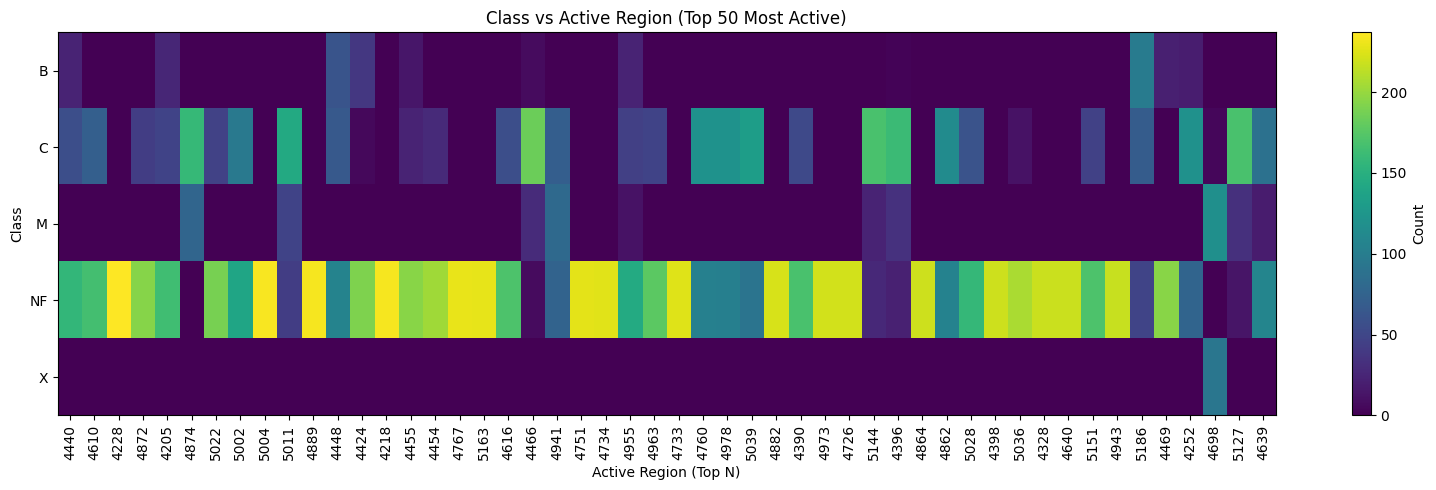

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = result.copy()
df["active_region"] = pd.to_numeric(df["active_region"], errors="coerce")
df = df.dropna(subset=["active_region"])
df["active_region"] = df["active_region"].astype(int)

ct = pd.crosstab(df["class"], df["active_region"])

# pick top N regions by total activity
top_n = 50
top_regions = ct.sum(axis=0).sort_values(ascending=False).head(top_n).index
ct_top = ct[top_regions]

plt.figure(figsize=(16, 5))
plt.imshow(ct_top.values, aspect="auto")
plt.colorbar(label="Count")

plt.yticks(range(ct_top.shape[0]), ct_top.index)
plt.xticks(range(ct_top.shape[1]), ct_top.columns, rotation=90)

plt.xlabel("Active Region (Top N)")
plt.ylabel("Class")
plt.title(f"Class vs Active Region (Top {top_n} Most Active)")
plt.tight_layout()
plt.show()


In [ ]:
#

In [6]:
result.columns

Index(['class', 'flare_id', 'active_region', 'start_time', 'end_time',
       'TOTUSJH_Max', 'TOTUSJH_Min', 'TOTUSJH_Median', 'TOTUSJH_Mean',
       'TOTUSJH_Std_dev',
       ...
       'R_VALUE_Mean', 'R_VALUE_Std_dev', 'R_VALUE_Variance',
       'R_VALUE_Skewness', 'R_VALUE_Kurtosis',
       'R_VALUE_avg_abs_derivative_change', 'R_VALUE_last_value',
       'R_VALUE_average_absolute_change',
       'R_VALUE_quadratic_weighted_moving_average',
       'R_VALUE_linear_weighted_moving_average'],
      dtype='object', length=317)

In [7]:
data_prep = result.copy()

In [8]:
data_prep = data_prep.drop(columns=['flare_id'])

In [9]:
data_prep

,class,active_region,start_time,end_time,TOTUSJH_Max,TOTUSJH_Min,TOTUSJH_Median,TOTUSJH_Mean,TOTUSJH_Std_dev,TOTUSJH_Variance,...,R_VALUE_Mean,R_VALUE_Std_dev,R_VALUE_Variance,R_VALUE_Skewness,R_VALUE_Kurtosis,R_VALUE_avg_abs_derivative_change,R_VALUE_last_value,R_VALUE_average_absolute_change,R_VALUE_quadratic_weighted_moving_average,R_VALUE_linear_weighted_moving_average
0,M,4874,2014-12-04T03:24:00,2014-12-04T15:12:00,2785.852833,2491.531685,2641.136226,2620.825580,90.493670,8189.104400,...,4.654618,0.085263,0.007270,-0.324078,-1.191564,0.003174,4.774954,0.023202,4.712566,4.695854
1,M,5011,2015-01-03T17:36:00,2015-01-04T05:24:00,3219.186282,2806.196014,2931.875374,2958.810152,105.426848,11114.820218,...,4.624520,0.112293,0.012610,-0.216595,-1.097424,0.003077,4.454785,0.024048,4.531087,4.563562
2,M,4781,2014-11-05T17:00:00,2014-11-06T04:48:00,4240.705267,3548.885212,3889.603145,3864.781382,224.197421,50264.483419,...,5.325489,0.016920,0.000286,0.343941,0.095240,0.001215,5.316678,0.010504,5.318351,5.319844
3,M,4781,2014-11-05T22:00:00,2014-11-06T09:48:00,4384.021730,3866.071556,4111.197138,4119.445572,158.696759,25184.661170,...,5.294639,0.040382,0.001631,-1.594406,1.613134,0.001089,5.177362,0.009298,5.264564,5.278021
4,M,4781,2014-11-08T15:00:00,2014-11-09T02:48:00,3598.551137,3122.532031,3397.790137,3365.688336,154.227212,23786.032956,...,4.790613,0.031215,0.000974,0.312492,-0.321891,0.001609,4.752749,0.012820,4.770827,4.779305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51256,B,4272,2014-06-24T18:36:00,2014-06-25T06:24:00,992.661572,852.157091,949.046185,935.832556,37.344589,1394.618351,...,4.347464,0.079230,0.006277,-0.365231,-0.543393,0.004014,4.158737,0.030818,4.286448,4.307739
51257,NF,5006,2014-12-28T10:00:00,2014-12-28T21:48:00,12.656314,6.097119,9.315705,9.356092,1.636295,2.677460,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
51258,NF,4469,2014-08-26T21:48:00,2014-08-27T09:36:00,322.016807,226.421381,298.731413,290.855592,25.632848,657.042912,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
51259,NF,5020,2014-12-31T05:48:00,2014-12-31T17:36:00,141.255501,1.032144,113.458711,99.417747,33.979757,1154.623911,...,1.610879,1.241859,1.542213,-0.409658,-1.620817,0.081091,0.000000,0.538215,1.155247,1.390143


In [10]:
data_prep['class'] = data_prep['class'].isin(['B','C','M','X']).astype(int)

In [11]:
data_prep

,class,active_region,start_time,end_time,TOTUSJH_Max,TOTUSJH_Min,TOTUSJH_Median,TOTUSJH_Mean,TOTUSJH_Std_dev,TOTUSJH_Variance,...,R_VALUE_Mean,R_VALUE_Std_dev,R_VALUE_Variance,R_VALUE_Skewness,R_VALUE_Kurtosis,R_VALUE_avg_abs_derivative_change,R_VALUE_last_value,R_VALUE_average_absolute_change,R_VALUE_quadratic_weighted_moving_average,R_VALUE_linear_weighted_moving_average
0,1,4874,2014-12-04T03:24:00,2014-12-04T15:12:00,2785.852833,2491.531685,2641.136226,2620.825580,90.493670,8189.104400,...,4.654618,0.085263,0.007270,-0.324078,-1.191564,0.003174,4.774954,0.023202,4.712566,4.695854
1,1,5011,2015-01-03T17:36:00,2015-01-04T05:24:00,3219.186282,2806.196014,2931.875374,2958.810152,105.426848,11114.820218,...,4.624520,0.112293,0.012610,-0.216595,-1.097424,0.003077,4.454785,0.024048,4.531087,4.563562
2,1,4781,2014-11-05T17:00:00,2014-11-06T04:48:00,4240.705267,3548.885212,3889.603145,3864.781382,224.197421,50264.483419,...,5.325489,0.016920,0.000286,0.343941,0.095240,0.001215,5.316678,0.010504,5.318351,5.319844
3,1,4781,2014-11-05T22:00:00,2014-11-06T09:48:00,4384.021730,3866.071556,4111.197138,4119.445572,158.696759,25184.661170,...,5.294639,0.040382,0.001631,-1.594406,1.613134,0.001089,5.177362,0.009298,5.264564,5.278021
4,1,4781,2014-11-08T15:00:00,2014-11-09T02:48:00,3598.551137,3122.532031,3397.790137,3365.688336,154.227212,23786.032956,...,4.790613,0.031215,0.000974,0.312492,-0.321891,0.001609,4.752749,0.012820,4.770827,4.779305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51256,1,4272,2014-06-24T18:36:00,2014-06-25T06:24:00,992.661572,852.157091,949.046185,935.832556,37.344589,1394.618351,...,4.347464,0.079230,0.006277,-0.365231,-0.543393,0.004014,4.158737,0.030818,4.286448,4.307739
51257,0,5006,2014-12-28T10:00:00,2014-12-28T21:48:00,12.656314,6.097119,9.315705,9.356092,1.636295,2.677460,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
51258,0,4469,2014-08-26T21:48:00,2014-08-27T09:36:00,322.016807,226.421381,298.731413,290.855592,25.632848,657.042912,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
51259,0,5020,2014-12-31T05:48:00,2014-12-31T17:36:00,141.255501,1.032144,113.458711,99.417747,33.979757,1154.623911,...,1.610879,1.241859,1.542213,-0.409658,-1.620817,0.081091,0.000000,0.538215,1.155247,1.390143


In [12]:
data_prep.to_csv('../data/ABT_partition4.csv',index=False)

In [27]:
data_prep = data_prep.drop(['start_time','end_time'],axis=1)

In [ ]:
# def add_gaussian_noise(df,column,minority=1,samples=30000,sigma =0.01):

#     flare_df = df[df[column]== minority].copy()

#     sample_rows = flare_df.sample(n=samples,replace=True,random_state=42).copy()

#     X = sample_rows.drop(columns=[column])

#     feature_std = X.std(axis=0).replace(0,1e-6)

#     noise = np.random.normal(loc=0,scale=sigma,size=X.shape) * feature_std.values

#     X_noise = X + noise

#     sampled_noise = pd.DataFrame(X_noise,columns=X.columns)
#     sampled_noise[column] = minority

#     final_df = pd.concat([flare_df,sampled_noise],ignore_index=True)
    
#     print(flare_df)
#     return final_df

In [ ]:
def add_gaussian_noise(df, column, minority=1, samples=30000, sigma=0.01):
    
    flare_df = df[df[column] == minority].copy()
    sample_rows = flare_df.sample(n=samples, replace=True, random_state=42).copy()
    
    X = sample_rows.drop(columns=[column])
    
   
    X_numeric = X.select_dtypes(include=[np.number])
    
    feature_std = X_numeric.std(axis=0).replace(0, 1e-6)#double chjeck 
    noise = np.random.normal(loc=0, scale=sigma, size=X_numeric.shape) * feature_std.values
    X_noise = X_numeric + noise
    
    sampled_noise = pd.DataFrame(X_noise, columns=X_numeric.columns)
    
    # Add back non-numeric columns if needed
    for col in X.columns:
        if col not in X_numeric.columns:
            sampled_noise[col] = sample_rows[col].values
    
    sampled_noise[column] = minority
    final_df = pd.concat([df, sampled_noise], ignore_index=True)
    # print(flare_df)
    return final_df

In [ ]:
add_gaussian_noise(data_prep,'class')

0        3688
1        3366
2        4197
3        3686
4        3686
         ... 
72505    3719
72506    3719
72507    4000
72508    3330
72509    3686
Name: active_region, Length: 72510, dtype: object

In [34]:
data_prep

,class,active_region,TOTUSJH_Max,TOTUSJH_Min,TOTUSJH_Median,TOTUSJH_Mean,TOTUSJH_Std_dev,TOTUSJH_Variance,TOTUSJH_Skewness,TOTUSJH_Kurtosis,...,R_VALUE_Mean,R_VALUE_Std_dev,R_VALUE_Variance,R_VALUE_Skewness,R_VALUE_Kurtosis,R_VALUE_avg_abs_derivative_change,R_VALUE_last_value,R_VALUE_average_absolute_change,R_VALUE_quadratic_weighted_moving_average,R_VALUE_linear_weighted_moving_average
0,1,3688,2234.206232,1812.025600,1936.642763,1966.858921,111.419294,12414.259087,0.876615,-0.104981,...,4.172024,0.125432,0.015733,-0.264967,-0.965933,0.004286,4.351332,0.035149,4.199851,4.176571
1,1,3366,4350.649277,4118.376480,4226.909294,4227.494042,58.945367,3474.556250,-0.099436,-0.864929,...,5.257409,0.060914,0.003711,0.123103,-1.382054,0.001643,5.186335,0.012475,5.208395,5.224619
2,1,4197,5971.995387,5427.601612,5685.931906,5676.449862,151.055841,22817.867146,0.042406,-0.850779,...,5.310882,0.069291,0.004801,0.055277,-1.166496,0.001108,5.413816,0.009224,5.369353,5.349381
3,1,3686,8722.341628,7849.455657,8161.169937,8172.512223,234.807174,55134.408776,0.503287,-0.733850,...,5.235223,0.082162,0.006751,0.449198,-1.156580,0.001324,5.396841,0.010436,5.304679,5.277076
4,1,3686,9240.027830,7849.455657,8572.241393,8476.056740,426.958915,182293.915002,-0.085316,-1.483254,...,5.228545,0.062445,0.003899,-0.256370,-1.382391,0.001280,5.166364,0.010703,5.180559,5.197977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42505,0,3320,67.561541,52.969193,59.883312,60.457297,3.201471,10.249419,0.514122,-0.254304,...,0.059618,0.323763,0.104823,5.333765,27.360505,0.005126,1.790846,0.030353,0.171589,0.116305
42506,1,3415,789.630346,698.124698,748.062765,737.484348,26.081033,680.220286,-0.050935,-1.415573,...,1.920342,1.066029,1.136418,-1.103907,-0.381099,0.063195,0.000000,0.425484,1.324007,1.572680
42507,0,3705,11.522003,2.662429,5.113660,5.602774,2.237173,5.004944,0.925693,0.109049,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42508,0,3996,1006.345520,844.060934,928.770780,931.624050,39.566040,1565.471495,-0.330733,-0.127513,...,4.876126,0.054204,0.002938,-0.483670,-0.286243,0.002584,4.782547,0.019712,4.833546,4.850094


In [ ]:
# add_gaussian_noise(data_prep,'class').to_csv('../data/ABT_mgn_xg.csv')
